[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/transfer-learning/blob/master/transferlearning1.ipynb)

In [1]:
!pip install torch

    100% |████████████████████████████████| 484.0MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b8d0000 @  0x7f96cee511c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install torchvision
!pip install pillow==4.0.0

    100% |████████████████████████████████| 61kB 5.7MB/s 
    100% |████████████████████████████████| 2.0MB 11.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

plt.ion()

In [4]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

cuda:0
['ants', 'bees', 'bees', 'ants']


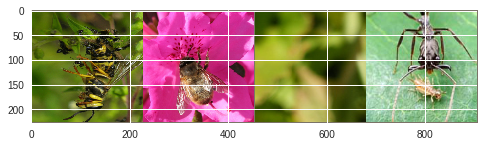

In [17]:
root='drive/app/hymenoptera_data'
data_transform={'train':transforms.Compose([transforms.RandomResizedCrop(224)
                                            ,transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
                'val':transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ])}
dataset={x:datasets.ImageFolder(root+'/'+x,transform=data_transform[x]) for x in ['train','val']}
data={x:torch.utils.data.DataLoader(dataset[x],batch_size=4,shuffle=True,num_workers=2) for x in ['train','val']}
datalen={x:len(dataset[x]) for x in ['train','val']}
classtr=dataset['train'].classes
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
def imshow(image,classim):
  image=image.numpy()
  image=image.transpose((1,2,0))
  mean=np.array([0.485, 0.456, 0.406])
  std=np.array([0.229, 0.224, 0.225])
  image=np.clip(image*std+mean,0,1)
  
  plt.imshow(image)
  print(classim)
 
  
  
  
  
plt.figure() 
a=iter(data['train'])  
image,classes=next(a)

imagetogrid=torchvision.utils.make_grid(image)
classe=[classtr[x] for x in classes]
imshow(imagetogrid,classe)

plt.show()



In [0]:
def train_model(model,losstype,optimizer,scheduler):
  numofepoch=50
  start=time.time()
  best_model_weight=copy.deepcopy(model.state_dict())
  best_accuracy=0.0
  for epoch in range(numofepoch):
    print(epoch,"epoch out of",numofepoch-1)
    for phase in ['train','val']:
      if phase=='train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss=0
      running_correct=0
      for inputs,label in data[phase]:
        inputs.to(device)
        label.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
         
          output=model(inputs)
          predict=torch.max(output,1)
          loss=losstype(output,label)
          if phase=='train':
            loss.backward()
            optimizer.step()
        running_loss+=loss.item()*inputs.size()[0]
        running_correct+=torch.sum(predict[1]==label)
      epoch_loss=running_loss/datalen[x]
      epoch_accuracy=running_corect/datalen[x]
      
      print('epoch loss:',epoch_loss,"epoch_accuracy:",epoch_accuracy)  
      if (epoch_accuracy>best_accuracy):
        best_model_weight=model.state_dict()
    model.load_state_dict(best_model_weight)
    print('time taken in each epoch:',time.time()-since)
    return model

In [31]:
model=models.resnet18(pretrained=True)
# for parameter in  model.parameters():
#    parameter.requires_grad=False  if u want to freeze previous layers
num_feature=model.fc.in_features
model.fc=nn.Linear(num_feature,2)
if torch.cuda.device_count()>1:
  model=nn.DataParallel(model)
model.to(device)
print(model.conv1.weight.type())
losstype=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.95)
scheduler=lr_scheduler.StepLR(optimizer,gamma=0.01,step_size=10)
model=train_model(model,losstype,optimizer,scheduler)





torch.cuda.FloatTensor
0 epoch out of 49


RuntimeError: ignored

In [14]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])
